# Homework 5: Stochastic gradient algorithms#


Link to homework - http://www.harchaoui.eu/zaid/teaching/nyu/fall2015/cml_hw5.pdf

### 2) Linear Support Vector Machines ###
#### 2.1 Linear SVMs with gradient descent####
##### 2.1.1 Making our job easier#####

In [237]:
%matplotlib inline
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt

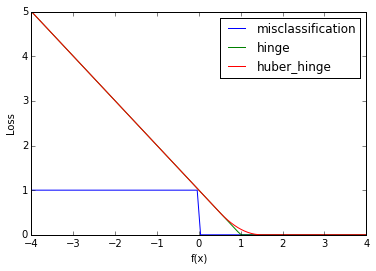

In [238]:
'''
Plotting the misclassification error loss, the (regular) hinge 
loss and the huberized hinge loss.

'''
f_x = np.linspace(-4, 4, 100)


def misclassification(f_x):
    return [1 if i <= 0 else 0 for i in f_x ]

def hinge(f_x):
    #consider y (predicted value) = 1
    return [np.max([0, 1-i]) for i in f_x ]

def huber_hinge(y, t ):
    
    y = np.array(y)
    t = np.array(t)
    
    z = y*t
    h = 0.5
    loss = np.zeros(z.shape)
    
    loss = np.where(z > 1+h, 0, loss)
    loss = np.where( abs(1-z) <= h, ( 1+h-z)**2 / (4*h), loss )
    loss = np.where( z < 1-h, 1 - z, loss)
    
    '''
    This is equivalent to -
    
    for i, x in enumerate(z):
        if x > 1+h:
            loss[i] = 0
        elif abs(1-x) <= h:
            loss[i] = ((1+h-x)**2)/(4*h)
        else:
            loss[i] = 1-x
            
    '''
    
    return loss

plt.plot(f_x, misclassification(f_x), label = 'misclassification')
plt.plot(f_x, hinge(f_x), label = 'hinge')
plt.plot(f_x, huber_hinge(1, f_x), label = 'huber_hinge')


plt.legend(loc="upper right")
plt.xlabel("f(x)")
plt.ylabel("Loss")


The hinge loss has a sharp kink at f(x) = 1 and is thus non-differentiable. Therefore, we use huber-hinge loss function which is differentiable to  compute gradient and optimize the objective.


Huber hinge loss is defined as-

$l_{huber-hinge}(y,t) := \begin{cases} 0 & \mbox{ if } yt > 1 + h \\
\frac{(1+h-yt)^2}{4h} & \mbox{ if } | 1- yt | \leq h \\
1 - yt & \mbox{ if } yt < 1- h 
\end{cases}$

To prove that $l_{huber-hinge}$ is differntiable, we need to prove that it is differentiable in each interval and at the connecting point of the interval. It is differentiable in each interval as it is a polynomial function.

At the connecting point,  $t = \frac{1 \pm h}{y}$.


Taking partial derivative w.r.t t -

$\partial_{t} (0) = 0$

$\partial_{t} ( \frac{(1+h-yt)^2}{4h}) = - \frac{ (1+h -yt) y}{2h} $

$\partial_{t} ( 1 - yt ) = -y$

Therefore, at the connecting points, $t = \frac{1 \pm h}{y}$,

$\partial_t [ \frac{(1+h-yt)^2}{4h} ]$ where $t =(\frac{1\pm h}{y}) = \begin{cases} 
0 \\
-y
\end{cases}$

Comparing this with the derivatives above, we can see that $l_{huber-hinge}$ is differentiable.

Also,  $\partial_t l_{huber-hinge} \leq |y| = 1$. Any differentiable function with a bounded derivative is  Lipschitz continuous. Hence,  $\partial_t l_{huber-hinge}$ is 1-Lipschitz.

##### 2.1.2 Analytic expressions #####

Objective function - 

$ F(\vec{w}) = \vec{w} \cdot \vec{w} + \frac{C}{n} [ l_{huber-hinge}( \vec{y}, X\vec{w}) \cdot \vec{1} ]$

By calculating the dot product with a n-dimensional one vector, we can calculate the sum indirectly.

The gradient of the objective function is calculated by calculating the derivative with respect to the vector w. For each component, this can be written as-

$\partial_{w_i} F(\vec{w})= 2w_i + \frac{C}{n} [ \partial_t l_{huber-hinge} ] (\vec{y}, X\vec{w}) \cdot \begin{bmatrix}
x_{1i} \\
\vdots \\
x_{ni}
\end{bmatrix}$

Therefore, the expression for the gradient is-

$\nabla_w F(\vec{w}) = 2 \vec{w} + \frac{C}{n} [ \partial_t l_{hunber-hinge}] (\vec{y}, X\vec{w}) X$


The derivative over each interval of the huber-hinge loss function was calculated above.

In [239]:
def compute_obj(w, X, y):
        
    f_x = np.dot(X, w)
    n = X.shape[0]
        
    F = np.dot(w,w) + float(C/n) * np.dot(huber_hinge(y, f_x), np.ones(X.shape[0]))

    return F

#compute derivative of huber hinge loss function
def huber_diff(Y,T):
    
    Y = np.array(Y)
    T = np.array(T)
    
    z = Y*T
    h = 0.5
    
    loss = np.zeros(Y.shape)
    
    loss = np.where(z > 1+h, 0, loss)
    loss = np.where( abs(1-z) <= h, -((1+h-z)*Y)/(2*h), loss )
    loss = np.where( z < 1-h, -Y, loss)
    
    '''
    This is equivalent to -
    
    for i, (y, t) in enumerate(zip(Y,T)):
        if y*t > 1+h:
            loss[i] = 0
        elif abs(1-y*t) <= h:
            loss[i] = -((1+h-y*t)*y)/(2*h)
        else:
            loss[i] = -y
            
    '''
    return loss

def compute_grad(w, X, y):

    f_x = np.dot(X,w)
    n = X.shape[0]
        
    G = 2* w + float(C/n) * np.dot(huber_diff(y, f_x),  X)
    return G

##### 2.1.3 Numerical checks #####


In [240]:
from sklearn import preprocessing

def grad_checker(compute_grad, compute_obj, X, y):
    e = 1e-4
    #print(X)
    check = []
    
    w = []
    for i in range(X.shape[1]):
        w.append(np.random.random())
        
    w = np.array(w)
    
    for index in range(X.shape[1]):
        
        basis = np.zeros(X.shape[1])
        basis[index] = 1.0
        
        w_plus = w + e * basis
        w_minus = w - e * basis
        num = (compute_obj(w_plus, X, y) - compute_obj(w_minus, X, y))/(2*e)
        check.append(num)    
        
    
    gradient = compute_grad(w, X, y)
    gradient = np.array(gradient)
    check = np.array(check)
  
    return np.linalg.norm(gradient - check)

'''
The grad_checker function is used after the my_gradient_descent function and the dataset are declared.
'''

'\nThe grad_checker function is used after the my_gradient_descent function and the dataset are declared.\n'

##### 2.1.4 Gradient Descent #####

In [241]:
'''
Simplest version of gradient descent algorithm.
'''

def my_gradient_descent(n, max_iter, X, y, compute_grad, compute_obj, w):
    
   
    obj = [None]*max_iter
    
    error = np.zeros(max_iter)
    
    for i in range(max_iter):
        
        # To calculate misclassification error
        #
        num_error = 0
        for X_i, y_i in zip(X, y):
            if (y_i * np.sign(np.dot(w,X_i)) <= 0):
                num_error += 1
        
        error[i] = num_error
        
        obj[i] = compute_obj(w, X, y)
        w = w - n* compute_grad(w,X, y)
        
        
    return w, obj, error



In [242]:
from sklearn.cross_validation import train_test_split

'''
Dataset consisiting of 2 gaussians with minimum/no overlap.
'''
def dataset(n, dim):
   
    np.random.seed(0)
    C = np.array([[0., -0.25], [0.80, .25]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 2])]
    y = np.hstack((-1*np.ones(n), np.ones(n)))
    return X, y

x, y = dataset(500, 2)
x = np.column_stack( (x, np.ones(x.shape[0])))
x = preprocessing.scale(x)
rng = np.random.RandomState(0)
permutation = rng.permutation(len(x))
x_mod, y_mod = x[permutation], y[permutation]


X_train, X_test, y_train, y_test = train_test_split(x_mod, y_mod, test_size=0.5)



In [243]:
C = 1
print(grad_checker(compute_grad, compute_obj, X_train, y_train))


2.61970124346e-12


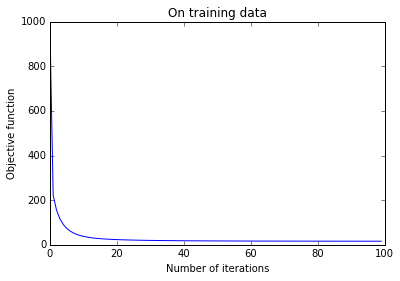

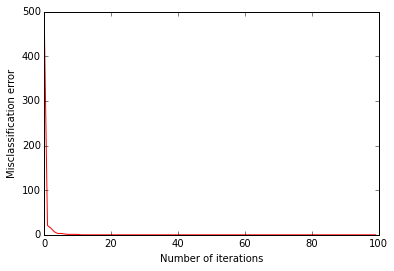

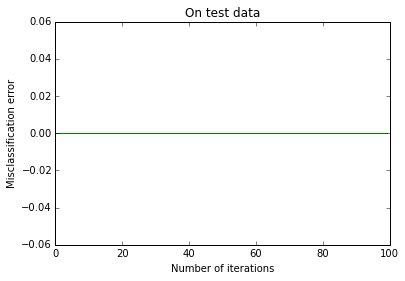

In [244]:
'''
C = 1 did not give good results and hence C = 1000 is used.
'''
C= 1000
w = np.zeros(X_train.shape[1])
w, obj, error = my_gradient_descent(0.001, 100, X_train, y_train ,compute_grad, compute_obj, w)
index = [i for i in range (100)]

'''
On the training set, w is initialized to all zeros. On the test set, w that is obtained by 
running gradient descent on the training data is used.
'''
plt.title("On training data")
plt.plot(index, obj)
plt.xlabel("Number of iterations")
plt.ylabel("Objective function")
plt.figure()
plt.plot(index, error, "-r")
plt.xlabel("Number of iterations")
plt.ylabel("Misclassification error")



w1, obj1, error1 = my_gradient_descent(0.001, 100, X_test, y_test ,compute_grad, compute_obj, w)
plt.figure()
plt.title("On test data")
plt.plot(index, error1, "-g")
plt.xlabel("Number of iterations")
plt.ylabel("Misclassification error")


To optimize F and reduce the misclassification error, I modified the parameters C and n (step size). C= 1000 and n = 0.001 with number of iterations = 100 seems to give a misclassification error of 0 after about 25 iterations.

If the step size is too small, it takes more iterations to get the best performance in terms of misclassification error on the data. If the step size is too big, the objective function and the misclassfication error keep oscillating back and forth and do not converge to an optimum value.

In [253]:
'''
gradient descent algorithm with backtracking line search

Reference: http://users.ece.utexas.edu/~cmcaram/EE381V_2012F/Lecture_4_Scribe_Notes.final.pdf
'''

def gradient_backtracking(max_iter, X, y,compute_grad, compute_obj, w):
    
    alpha = 0.1 # chosen between 0.01 and 0.3
    beta = 0.8 #between 0.1 and 0.8
    
    n = 1 #initial step size
    
    
    obj = [None]*max_iter
    mis = np.zeros(max_iter)
    
    for k in range(max_iter):
        
        grad = compute_grad(w, X, y)
        obj[k] = compute_obj(w, X, y)
        
        num_error = 0
        for X_i, y_i in zip(X, y):
            if (y_i * np.sign(np.dot(w,X_i)) <= 0):
                num_error += 1
        mis[i] = num_error
        
        while compute_obj((w - n*grad), X, y) > (compute_obj(w, X, y) - alpha*n* np.dot(grad, grad)):
            n = beta * n
        
        
        w = w- n*compute_grad(w, X, y)
        
    return w, obj, mis

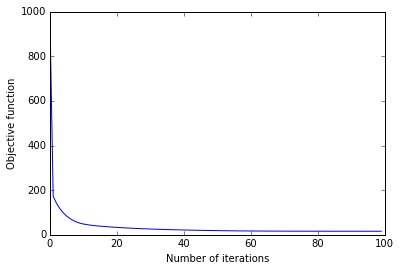

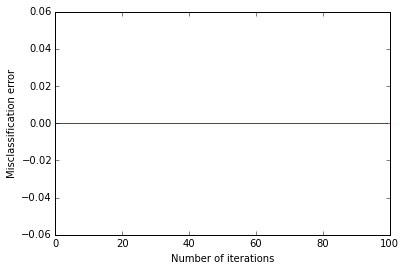

In [255]:
C = 1000
w = np.zeros(X_train.shape[1])

w6, obj6, error6 = gradient_backtracking( 100, X_train, y_train ,compute_grad, compute_obj, w)
index6 = [i for i in range (len(obj))]

plt.plot(index6, obj6)
plt.xlabel("Number of iterations")
plt.ylabel("Objective function")
plt.figure()


plt.plot(index6, error6, "-r")
plt.xlabel("Number of iterations")
plt.ylabel("Misclassification error")


In [247]:
import cProfile
cProfile.run('gradient_backtracking( 100, X_train, y_train ,compute_grad, compute_obj, w)')

         59137 function calls in 0.152 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      444    0.008    0.000    0.014    0.000 <ipython-input-238-713182317a3e>:16(huber_hinge)
      444    0.002    0.000    0.021    0.000 <ipython-input-239-c667802ef51c>:1(compute_obj)
      200    0.003    0.000    0.006    0.000 <ipython-input-239-c667802ef51c>:11(huber_diff)
      200    0.001    0.000    0.008    0.000 <ipython-input-239-c667802ef51c>:39(compute_grad)
        1    0.074    0.074    0.152    0.152 <ipython-input-245-06978b02c9b9>:7(gradient_backtracking)
        1    0.000    0.000    0.152    0.152 <string>:1(<module>)
      444    0.001    0.000    0.002    0.000 numeric.py:141(ones)
      644    0.001    0.000    0.001    0.000 {abs}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
    51904    0.039    0.000    0.039    0.000 {numpy.core._dotblas.dot}
     1288    0

After profiling the code, it is found that the bottlenecks are the functions huber_hinge and huber_diff. Previously, I was using the append function to add to the list that stored the loss function calculation. Adding an element by specifying the index (loss[i] = ...) improved the performance. Using np.where() function improved teh performance even further.

In [248]:
import cProfile
cProfile.run('my_gradient_descent(0.001, 100, X_train, y_train ,compute_grad, compute_obj, w)')

         52705 function calls in 0.148 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    0.003    0.000    0.005    0.000 <ipython-input-238-713182317a3e>:16(huber_hinge)
      100    0.001    0.000    0.009    0.000 <ipython-input-239-c667802ef51c>:1(compute_obj)
      100    0.002    0.000    0.003    0.000 <ipython-input-239-c667802ef51c>:11(huber_diff)
      100    0.001    0.000    0.005    0.000 <ipython-input-239-c667802ef51c>:39(compute_grad)
        1    0.081    0.081    0.148    0.148 <ipython-input-241-9662a7177fdc>:5(my_gradient_descent)
        1    0.000    0.000    0.148    0.148 <string>:1(<module>)
      100    0.000    0.000    0.001    0.000 numeric.py:141(ones)
      200    0.000    0.000    0.000    0.000 {abs}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
    50500    0.041    0.000    0.041    0.000 {numpy.core._dotblas.dot}
      400    0.0

The gradient_backtracking function is slower than my_gradient_descent because there is an additional step to calculate the step size. (The code for calculation of misclassification error was commented out in my_gradient_descent).
Based on the graph, the number of iterations required to optimize F (the objective function) are less for the gradient descent algorithm with backtracking.

In [249]:
'''
Linear SVM with huberized hinge loss, trained using a gradient descent algorithm 
'''
def my_svm(n,max_iter, X, y, compute_grad, compute_obj):
    g = []
    w = np.zeros(X.shape[1])
    for x in X:
        
        w, o, e = gradient_backtracking(max_iter, X, y, compute_grad, compute_obj, w)
       
        f_x = np.dot(w, x)
        g.append(int(np.sign(f_x)))
     
        
    return w, g, obj



In [250]:
n = 0.001
w, g, obj = my_svm(n,100,X_train, y_train, compute_grad, compute_obj)


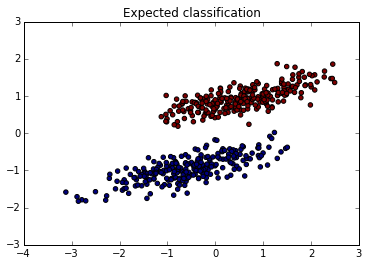

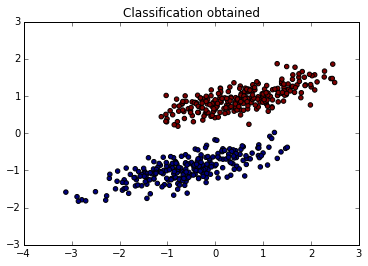

In [251]:
g = np.array(g)


plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title("Expected classification")

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=g)
plt.title("Classification obtained")





In [300]:
def one_step_gradient(w, n,alpha, beta, X, y):
    
    grad = compute_grad(w, X, y)
    obj = compute_obj(w, X, y)
    num_error = 0
    for X_i, y_i in zip(X, y):
        if (y_i * np.sign(np.dot(w,X_i)) <= 0):
            num_error += 1
       
    while compute_obj((w - n*grad), X, y) > (compute_obj(w, X, y) - alpha*n* np.dot(grad, grad)):
        n = beta * n
        w = w- n*compute_grad(w, X, y)
    
    return w, obj, n, num_error

In [325]:
'''
my_svm function modified to have different stopping criteria
'''
def my_svm_2( X, y, compute_grad, compute_obj, criteria):
    
    g = []
    w = np.zeros(X.shape[1])
    k = 0
    alpha = 0.1 # chosen between 0.01 and 0.3
    beta = 0.8 #between 0.1 and 0.8
    
    n = 1 #initial step size
    obj = []
    rho = 0.9
    error = []
    
    perf = []
    
    if criteria == 1:
        max_iter = input("Maximum number of iterations: ")
        obj = [None]*max_iter
        for x in X:
            for k in range(max_iter):
                w, obj[k], n, e = one_step_gradient(w,n,alpha, beta,X,y)
                error.append(e)
                
            f_x = np.dot(w, x)
            g.append(int(np.sign(f_x)))
     
        return w, g, obj, max_iter, error

    #optimization based criterion     
    elif criteria == 2:
        eps = 1e-3
        obj.append(compute_obj(w, X, y))
        grad = compute_grad(w, X, y)
        for x in X:
            k = 0
            while np.linalg.norm(grad) > eps:
                w, o, n, e = one_step_gradient(w,n,alpha, beta,X,y)
                grad = compute_grad(w, X, y)
                error.append(e)
                obj.append(o)
                k = k+1
                
            f_x = np.dot(w, x)
            g.append(int(np.sign(f_x)))
     
        return w, g, obj, k, error
   
    #generalization-performance based criterion
    elif criteria == 3:
        num_error = 0
        for X_i, y_i in zip(X, y):
            if (y_i * np.sign(np.dot(w,X_i)) <= 0):
                num_error += 1
        error.append(num_error)
        error.append(num_error)
        for x in X:
            t = 1
            while error[t] > rho * min(error[:t]):
                w, o, n, e = one_step_gradient(w,n,alpha, beta,X,y)
                grad = compute_grad(w, X, y)
                error.append(e)
                obj.append(o)
                t= t+1
                
            f_x = np.dot(w, x)
            g.append(int(np.sign(f_x)))
     
        return w, g, obj, t, error
   
        
    return w, g, obj, k, error
        

In [274]:
'''
Try to find the optimum value of C based on misclassification error
'''
C_list = [10**i for i in range(-5, 6)]
index = [i for i in range (100)]
obj_list = np.zeros(len(C_list))
error = []
w = np.zeros(X_train.shape[1])
for p in range(len(C_list)):
    C = C_list[p]
    w, obj, e = gradient_backtracking(100, X_train, y_train ,compute_grad, compute_obj, w)
    error.append(e[-1])
    
index_min = np.argmin(error)
print(C_list[index_min])



100


Therefore, the optimum value of C is 100.

Maximum number of iterations: 100


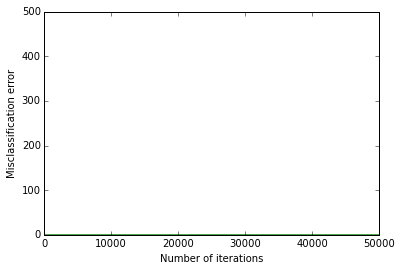

In [287]:
#Running my_svm with the first criteria- maximum number of iterations
C = 100
w, g, obj, k, e5 = my_svm_2(X_train, y_train, compute_grad, compute_obj, 1)

plt.plot([i for i in range(len(e5))], e5, "-g")
plt.xlabel("Number of iterations")
plt.ylabel("Misclassification error")

In [289]:
print(e5[-1])

0


The misclassification error is 0. 

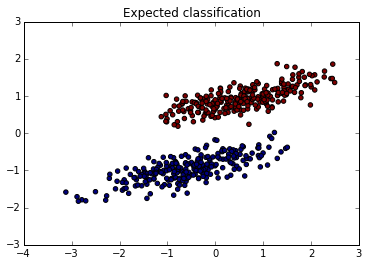

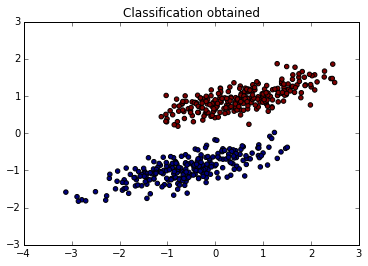

In [290]:
g = np.array(g)
X0, X1 = X_train[g == 1], X_train[g == -1]


plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title("Expected classification")

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=g)
plt.title("Classification obtained")



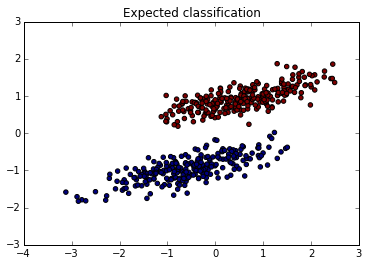

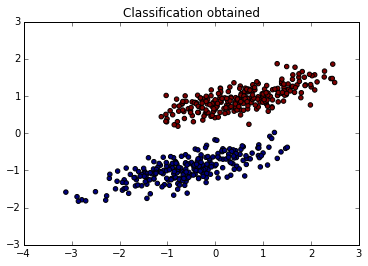

In [327]:
#Running my_svm with the second criteria- optimization based criterion

C = 100
w_2, g_3, obj_3, k, e6= my_svm_2(X_train, y_train, compute_grad, compute_obj, 2)

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title("Expected classification")

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=g_3)
plt.title("Classification obtained")




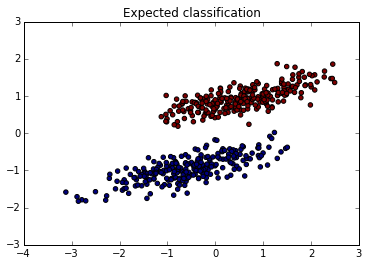

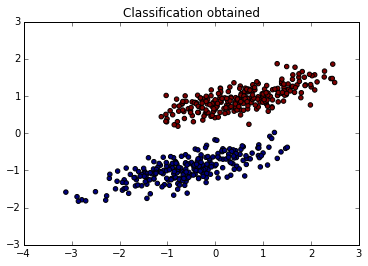

In [328]:
#Running my_svm with the third criteria-  generalization performance-based criterion

C = 100
w_7, g_7, obj_7, k7, e7= my_svm_2(X_train, y_train, compute_grad, compute_obj, 3)

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title("Expected classification")

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=g_7)
plt.title("Classification obtained")


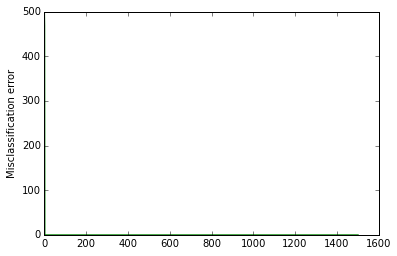

In [330]:

plt.plot([i for i in range(len(e7))], e7, "-g")
plt.ylabel("Misclassification error")

### Scikit-learn SVM##

1.0

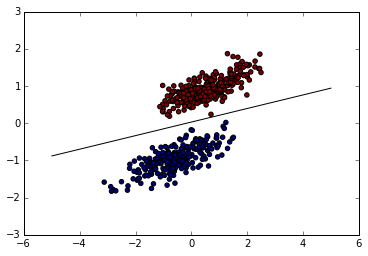

In [155]:
from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train, y_train)

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - clf.intercept_[0] / w[1]

plt.plot(xx, yy, 'k-')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

The scikit learn implementation gives a misclassification error of 0 as does our implementation.

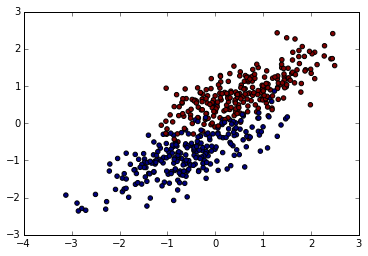

In [32]:
'''
Modify dataset to have some overlap
'''

from sklearn.cross_validation import train_test_split

def dataset2(n, dim):
   
    np.random.seed(0)
    C = np.array([[0., -0.25], [0.80, .25]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((-1*np.ones(n), np.ones(n)))
    return X, y

x1, y1 = dataset2(500, 2)
x1 = np.column_stack( (x1, np.ones(x1.shape[0])))
x1 = preprocessing.scale(x1)
rng = np.random.RandomState(0)
permutation = rng.permutation(len(x1))
x1_mod, y1_mod = x1[permutation], y1[permutation]


X_train1, X_test1, y_train1, y_test1 = train_test_split(x1_mod, y1_mod, test_size=0.5)

plt.scatter(X_train1[:, 0], X_train1[:, 1], c=y_train1)

Accuracy on training set:  0.942
Accuracy on test set:  0.92


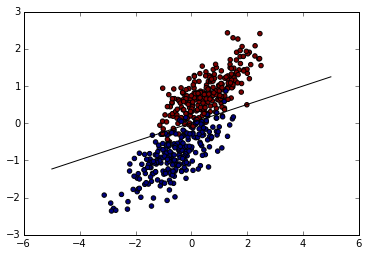

In [33]:
from sklearn import svm
clf = svm.LinearSVC()
clf.fit(X_train1, y_train1)

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - clf.intercept_[0] / w[1]

plt.plot(xx, yy, 'k-')
plt.scatter(X_train1[:, 0], X_train1[:, 1], c=y_train1)

print "Accuracy on training set: " , clf.score(X_train1, y_train1)
print "Accuracy on test set: " ,clf.score(X_test1, y_test1)

Maximum number of iterations: 100
31


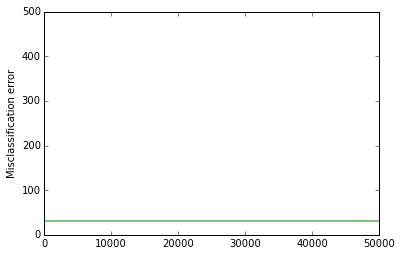

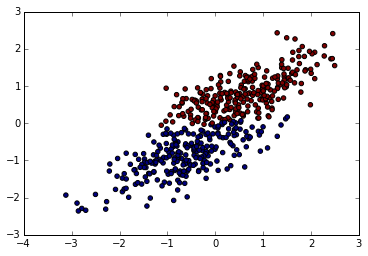

In [306]:
C = 100
w_3, g_3, obj_3, k3, e7 = my_svm_2(X_train1, y_train1, compute_grad, compute_obj, 1)

plt.plot([i for i in range(len(e7))], e7, "-g")
plt.ylabel("Misclassification error")

plt.figure()
plt.scatter(X_train1[:, 0], X_train1[:, 1], c=g_3)

print(e7[-1])

For datasets with more overlap, the accuracy of Sklearn implementation on training set is 0.94. My implementation gives a misclassification error of 31 which corresponds to an accuracy of 0.938.

It is slower than the sklearn implementation.

### 2.2 Stochastic Gradient Descent ###



The synthetic data generated has $10^4$ examples for training and $10^4$ for testing. my_svm2 is run on this dataset. It takes 131 s for one iteration. 

(The size of the dataset was chosen to be $10^4$ instead of $10^7$ (as asked for in the homework) because it was taking far too long.)

In [19]:
import time
C = 10000
x3, y3 = dataset(10**4, 2)
x3 = np.column_stack( (x3, np.ones(x3.shape[0])))
x3 = preprocessing.scale(x3)
rng = np.random.RandomState(0)
permutation = rng.permutation(len(x3))
x3_mod, y3_mod = x3[permutation], y3[permutation]


X_train2, X_test2, y_train2, y_test2 = train_test_split(x3_mod, y3_mod, test_size=0.5)

start = time.time()
w3, g3, obj3, k = my_svm_2(X_train2, y_train2, compute_grad, compute_obj, 1)
end = time.time()

print "Time for one iteration: ", end-start

Maximum number of iterations: 1
Time for one iteration:  131.021744013


Implementation of stochastic gradient descent algorithm-

In [155]:
import random
def my_sgd(n, max_iter, X, y ,compute_obj, compute_grad):
    
    obj = [None]*max_iter
    w = np.zeros(X.shape[1])
    error = np.zeros(max_iter)
    
    
    for i in range(1,max_iter+1):
        
        # To calculate misclassification error
        #
        num_error = 0
        for X_i, y_i in zip(X, y):
            if (y_i * np.sign(np.dot(w,X_i)) <= 0):
                num_error += 1
        
        error[i-1] = num_error
        
        index = random.randint(0,len(X)-1)
        x_r = X[index]
        y_r = y[index]
        obj[i-1] = compute_obj(w, x_r, y_r)
        
        #Decay the learning rate
        w = w - (n/i)* compute_grad(w,x_r, y_r)
        
        
    return w, obj, error


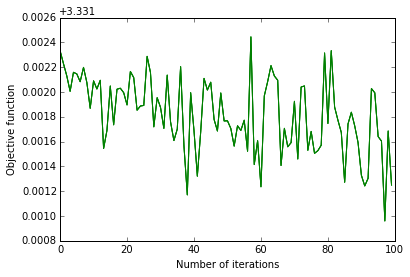

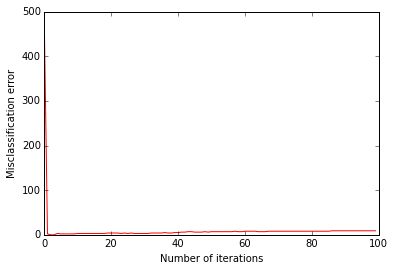

In [187]:
C = 10

w4, obj4, error4 = my_sgd( 0.00001, 100, X_train, y_train ,compute_obj, compute_grad)
index = [i for i in range (len(obj4))]

plt.plot(index, obj4, "-g")
plt.xlabel("Number of iterations")
plt.ylabel("Objective function")
plt.figure()


plt.plot(index, error4, "-r")
plt.xlabel("Number of iterations")
plt.ylabel("Misclassification error")

The objective function seems to vary a lot and not have a smooth descent curve but the final value is lower than the initial. The misclassification error is close to zero.


Comparing the time taken to run my_sgd and gradient_backtracking on the database of $10^4$ samples with 1000 iterations. 

In [182]:
import time
start = time.time()
my_sgd( 0.001, 1000, X_train2, y_train2 ,compute_obj, compute_grad)
end = time.time()
print('time per iteration: ' + str((end-start)/1000))

time per iteration: 0.0205759580135


In [183]:
import time
start = time.time()
gradient_backtracking( 1000, X_train2, y_train2 ,compute_grad, compute_obj, w)
end = time.time()
print('time per iteration: ' + str((end-start)/1000))

time per iteration: 0.0241592040062


The time taken per iteration for my_sgd is less. If the goal were to minimize the total time, SGD would be a better choice. If the goal is to minize the total number of steps required, batch gradient descent should be used.

In [307]:
'''
Function to select optimum step size
'''
def choose_step(w, n, X, y):
    alpha = 0.1 # chosen between 0.01 and 0.3
    beta = 0.8 #between 0.1 and 0.8
    
    grad = compute_grad(w, X, y)
    obj = compute_obj(w, X, y)
    
    while compute_obj((w - n*grad), X, y)[0] > (compute_obj(w, X, y)[0] - alpha*n* np.dot(grad, grad)):
        n = beta * n
        
    return n

In [309]:
'''
Modified stochastic geadient descent algorithm that uses the function above
to determine the optimum step size for that iteration.
'''
import random
def my_sgd_2(max_iter, X, y ,compute_obj, compute_grad):
    
    obj = [None]*max_iter
    w = np.zeros(X.shape[1])
    error = np.zeros(max_iter)
    n = 1
    
    for i in range(1,max_iter+1):
        
        # To calculate misclassification error
        #
        num_error = 0
        for X_i, y_i in zip(X, y):
            if (y_i * np.sign(np.dot(w,X_i)) <= 0):
                num_error += 1
        
        error[i-1] = num_error
        
        index = random.randint(0,len(X)-1)
        x_r = X[index]
        y_r = y[index]
        obj[i-1] = compute_obj(w, x_r, y_r)
       
        n = choose_step(w, n, x_r, y_r)
        w = w - (n/i)* compute_grad(w,x_r, y_r)
        
        
    return w, obj, error



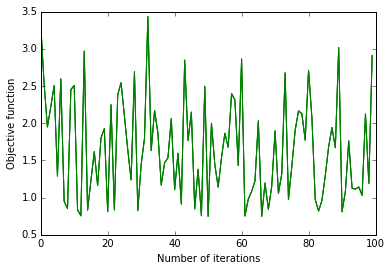

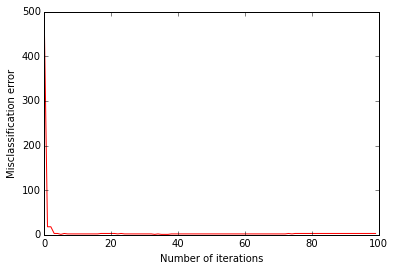

In [310]:
C = 10

w5, obj5, error5 = my_sgd_2( 100, X_train, y_train ,compute_obj, compute_grad)
index = [i for i in range (len(obj5))]

plt.plot(index, obj5, "-g")
plt.xlabel("Number of iterations")
plt.ylabel("Objective function")
plt.figure()


plt.plot(index, error5, "-r")
plt.xlabel("Number of iterations")
plt.ylabel("Misclassification error")

The function runs very fast (compared to gradient descent algorithm) and the misclassification error goes down to zero.



Maximum number of iterations: 100
Time for one iteration:  1253.54096007


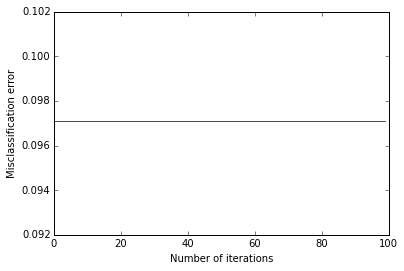

In [235]:
'''
For dataset with 1024 dimensions
'''
np.random.seed(0)
n = 10000
dim = 1024
C2 = np.array([[0., -0.25]*1024])
x5 = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 2]*512)]
y5 = np.hstack((-1*np.ones(n), np.ones(n)))

x5 = np.column_stack( (x5, np.ones(x5.shape[0])))
x5= preprocessing.scale(x5)
rng = np.random.RandomState(0)
permutation = rng.permutation(len(x5))
x5_mod, y5_mod = x3[permutation], y5[permutation]



X_train5, X_test5, y_train5, y_test5 = train_test_split(x5_mod, y5_mod, test_size=0.5)


start = time.time()
w6, g6, obj6, k = my_svm_2(X_train5, y_train5, compute_grad, compute_obj, 1)
end = time.time()
index = [i for i in range (len(obj6))]
plt.plot(index, obj6, "-r")
plt.xlabel("Number of iterations")
plt.ylabel("Misclassification error")

print "Time for one iteration: ", end-start

### 3) Project ###

The project part of the homework can be found in a different ipynb notebook titled "HW5_Project_Part" along with a pdf file "Ament_Bagul_Outline".

### 4) Feedback ###

It took way too long to complete this assignment. Python 2.7 gives the result of division of two integers (for eg: C/n in our case) as an int. Therefore, for the longest time, I had the vector w as all zeros and same with the objective and gradient function. 

